In [1]:
%matplotlib inline
main_path = './../../../Dropbox/McGill-publication/Papers/Multisite/'

import seaborn; seaborn.set()
import seaborn as sns
sns.set_style("whitegrid")
sns.set_color_codes("muted")

In [2]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

def load_file(path):
    mat = scipy.io.loadmat(path)
    return mat

path_csv = 'demographic_1000fcon_consolidated.csv'
demograph = pd.read_csv(path_csv, index_col=0)
#subj_names = demograph[demograph.multisite == 1].values[:,0]
subj_names = demograph[demograph.multisite == 1].index.values

conn = load_file(main_path + 'figures/connectomes_corr/connectome_basc_' + 'sub19738' + '.mat' )
conn.get('conn').shape

(4950, 1)

In [3]:
subj_names
print demograph.sex.mean(),demograph.sex.std()
print demograph.age.mean(),demograph.age.std()

0.417391304348 0.493844823612
23.8579710145 5.14782652818


In [4]:
np.sum(demograph.multisite == 8)

print(np.sum([23,26,198,19,20,22,19,31]))
print(np.sum([21,26,195,17,18,20,17,31]))

358
345


In [3]:
from sklearn import linear_model
from sklearn.preprocessing import normalize


def rmconf(x,conf):
    print(x.shape,conf.shape)
    reg = linear_model.LinearRegression(fit_intercept=True)
    reg.fit(normalize(conf), x)
    return  x - reg.predict(normalize(conf))
    

    

In [6]:
demograph.loc['sub19738'].values[[0,2,3]]

array([  0.22675753,  27.        ,   0.        ])

In [7]:
import re, os
path = main_path + '/figures/connectomes_corr/'
list_connectomes = os.listdir(path)

demog_tmp = list()
all_conn_sites = list()
groups_vec = []
demog_tmp=[]
k=0
for site in range(1,9):
    # retrieve the subject name for that site
    subj_names = demograph[demograph.multisite == site].index.values

    for subj_name in subj_names:
        try:
            subj_name = subj_name.replace(' ','')
            conn_vec = load_file(path + 'connectome_basc_' +subj_name+'.mat' ).get('conn')
            
            if k==0:
                all_conn_sites = conn_vec
                demog_tmp.append(demograph.loc[subj_name].values[[0,2,3]])
                k=1
            else:
                all_conn_sites = np.hstack([all_conn_sites , conn_vec])
                demog_tmp = np.vstack((demog_tmp,demograph.loc[subj_name].values[[0,2,3]]))
            
            groups_vec.append(site)
        except Exception as e: 
            print(e)
            pass
        
#print all_conn_sites.shape,demog_tmp.shape
groups_vec = np.array(groups_vec)



# detrend the connections
#detrended_conn_all = rmconf(all_conn_sites.T,demog_tmp)

list_conn_sites = list()
detrended_conn = list()
demog_data = list()
for site in range(1,9):
    # retrieve the subject name for that site
    subj_names = demograph[demograph.multisite == site].index.values
    
    #detrended_conn.append(detrended_conn_all[groups_vec == site,:])
    demog_data.append(demog_tmp[groups_vec == site,:])
    k=0
    for subj_name in subj_names:
        try:
            subj_name = subj_name.replace(' ','')
            conn_vec = load_file(path + 'connectome_basc_' +subj_name+'.mat' ).get('conn')
            if k==0:
                conns_stack = conn_vec
                k=1
            else:
                conns_stack = np.hstack([conns_stack , conn_vec])
        except Exception as e: 
            print(e)
            pass
        #print(conns_stack.shape)
    list_conn_sites.append(conns_stack.copy())
            
#list_conn_sites

import statsmodels.api as sm
#detrended_conn_all = rmconf(all_conn_sites.T,demog_tmp)



[Errno 2] No such file or directory: './../../../Dropbox/McGill-publication/Papers/Multisite//figures/connectomes_corr/connectome_basc_sub55760.mat'
[Errno 2] No such file or directory: './../../../Dropbox/McGill-publication/Papers/Multisite//figures/connectomes_corr/connectome_basc_sub24528.mat'
[Errno 2] No such file or directory: './../../../Dropbox/McGill-publication/Papers/Multisite//figures/connectomes_corr/connectome_basc_sub55760.mat'
[Errno 2] No such file or directory: './../../../Dropbox/McGill-publication/Papers/Multisite//figures/connectomes_corr/connectome_basc_sub24528.mat'


In [9]:
from Proteus.proteus.predic import clustering as hc
from Proteus.proteus.matrix import tseries as ts
from Proteus.proteus.visu import matrix as vis
import matplotlib.gridspec as gridspec
from scipy import stats
import statsmodels.stats.multitest as smm

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


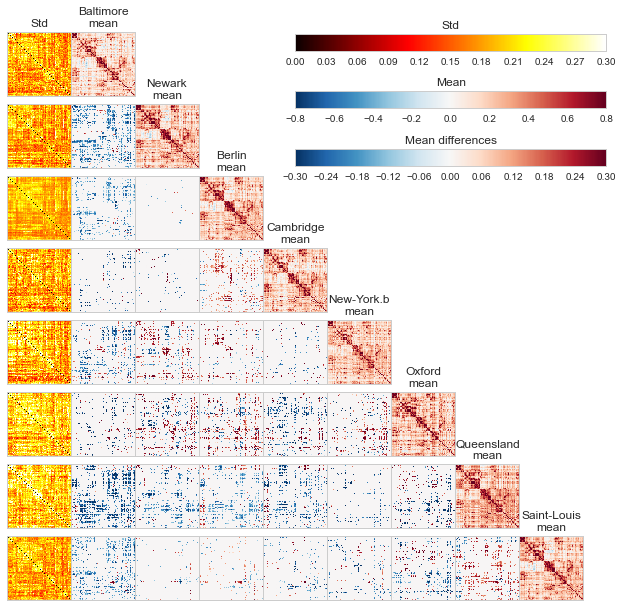

In [7]:


reload(vis)
#reload(vis.matrix)
reload(ts)
reload(hc)

def get_stats(conns):
    # compute the mean, std, ...   
    return ts.vec2mat(conns.mean(axis=1)), ts.vec2mat(conns.std(axis=1),val_diag=0)

def gen_fig(list_conn_sites):
    
    for sidx in range(0,len(list_conn_sites)):

        conn_vec = list_conn_sites[sidx]
        site_mean, site_std = get_stats(conn_vec)
        #print(site_mean.min(),site_mean.max(), site_std.min(),site_std.max())
        if sidx == 0:
            all_sites = site_mean
        else:
            all_sites = all_sites + site_mean
            
        all_sites = all_sites / len(list_conn_sites)

    order = hc.hclustering(all_sites, 100)
    #ordered_mat = hc.ordermat(all_sites,order)
    #vis.mat(ordered_mat)
    
    site_names = ['Baltimore','Newark','Berlin','Cambridge','New-York.b','Oxford','Queensland','Saint-Louis']
    lim_mean = [-0.8,0.8]
    lim_mean_diff = [-0.3,0.3]
    lim_std  = [0,.3]
    fig = plt.figure(figsize=(16, 16),dpi=150)
    fig.patch.set_facecolor('white')
    grid1 = gridspec.GridSpec(1,len(list_conn_sites)+1, wspace=0.0, hspace=0.0)
    grid1.update(wspace=0, hspace=0.0, bottom=0.0, top=0.5, left=0, right=0.5)
    for sidx in range(0,len(list_conn_sites)+1):
        
        if sidx > 0:
            conn_vec = list_conn_sites[sidx-1]
            site_mean, site_std = get_stats(conn_vec)
        
        # compare to all other sites
        for site_diff_idx in range(0,len(list_conn_sites)):
            grid2 = gridspec.GridSpecFromSubplotSpec(len(list_conn_sites),1, subplot_spec=grid1[sidx], wspace=0.0, hspace=0.0)
            #grid2 = gridspec.GridSpec(len(list_conn_sites), 2, subplot_spec=grid1[sidx], wspace=0.05, hspace=0.0)
            #gs2 = gridspec.GridSpec(len(list_conn_sites), 2)
            #grid2.update(left=0.05, right=0.48, wspace=0.05)
            
            if sidx == 0:
                # include the last std at the end of the 
                site_mean_tmp, site_std_tmp = get_stats(list_conn_sites[site_diff_idx])
                ax2 = plt.subplot(grid2[site_diff_idx,:])
                vis.mat(hc.ordermat(site_std_tmp,order),lim_std,False,False)
                #plt.ylabel('std')
                if site_diff_idx == 0:
                    plt.title('Std')
                
            else:
                if site_diff_idx == sidx-1:

                    #plt.imshow(site_std, interpolation="none")
                    #plt.delaxes()
                    ax1 = plt.subplot(grid2[site_diff_idx,:])
                    vis.mat(hc.ordermat(site_mean,order),lim_mean,False,False)
                    plt.title(site_names[sidx-1] + '\nmean')

                    """
                    if (sidx!=0):
                        site_mean_tmp, site_std_tmp = get_stats(list_conn_sites[site_diff_idx-1])
                        ax2 = plt.subplot(grid2[site_diff_idx-1,:])
                        vis.matrix.mat(site_std_tmp,[0,0.5],False,False)
                        plt.title('std')
                    """

                elif site_diff_idx > sidx-1:
                    conn_vec_tmp = list_conn_sites[site_diff_idx]
                    #t, prob = scipy.stats.ttest_ind(conn_vec,conn_vec_tmp)
                    #print demog_data[sidx-1]
                    x_1 = sm.tools.add_constant(demog_data[sidx-1])
                    x_2 = sm.tools.add_constant(demog_data[site_diff_idx])
                    x_ = np.vstack((x_1,x_2))
                    contrast = np.hstack((np.ones(x_1.shape[0]),np.zeros(x_2.shape[0])))
                    #print contrast.shape,x_.shape
                    x_ = np.hstack((contrast[:,np.newaxis],x_))
                    pval = []
                    for nn in range(conn_vec.shape[0]):
                        y_ = np.hstack((conn_vec[nn,:],conn_vec_tmp[nn,:]))
                        glm_ = sm.GLM(y_, x_)
                        res = glm_.fit()
                        #print(res.summary())
                        pval.append(res.pvalues[0])
                    pval = np.array(pval)
                    #conn_vec_tmp = detrended_conn[site_diff_idx]
                    #t,pval = stats.ttest_ind(detrended_conn[sidx-1],conn_vec_tmp, axis=0, equal_var = False)
                    rejected , pvaluecorrected = smm.multipletests(pval, alpha=0.05, method='fdr_bh')[:2]
                    rejected = ts.vec2mat(rejected)
                    #print conn_vec_tmp.shape
                    site_mean_tmp, site_std_tmp = get_stats(conn_vec_tmp)
                    #site_mean, site_std = get_stats(detrended_conn[sidx-1].T)
                    ax3 = plt.subplot(grid2[site_diff_idx,:])
                    #vis.mat(hc.ordermat(np.abs(site_mean - site_mean_tmp),order),lim_mean,False,False)
                    vis.mat(hc.ordermat((site_mean - site_mean_tmp)*rejected ,order),lim_mean_diff,False,False)
                    #vis.mat(hc.ordermat(rejected ,order),lim_mean_diff,False,False)
                    #print((site_mean - site_mean_tmp).min(), (site_mean - site_mean_tmp).max())

                    

    from sklearn import linear_model
    # include the color bars 1
    lim = lim_std
    cmap = vis.get_cmap(site_std, lim)
    ax_bar = fig.add_axes([0.25, 0.48, 0.27, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap, lim)
    plt.title('Std')

    # include the color bars 2
    lim = lim_mean
    cmap = vis.get_cmap(site_mean, lim)
    ax_bar = fig.add_axes([0.25, 0.43, 0.27, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap, lim)
    plt.title('Mean')

    # include the color bars 3
    lim = lim_mean_diff
    cmap = vis.get_cmap(site_mean, lim)
    ax_bar = fig.add_axes([0.25, 0.38, 0.27, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap, lim)
    plt.title('Mean differences')
    #plt.tight_layout()
    plt.savefig(main_path + 'figures/connectome_multisite.pdf')
    plt.savefig(main_path + 'figures/connectome_multisite.png')
    #plt.show()
                

gen_fig(list_conn_sites)

site_mean, site_std = get_stats(conns_stack)
#vis.matrix.mat(site_mean,[-1,1.3])
#vis.matrix.mat(site_mean)



# Matrix version 2

In [13]:
all_sites=[]
for sidx in range(0,len(list_conn_sites)):

        conn_vec = list_conn_sites[sidx]
        print conn_vec.shape
        #site_mean, site_std = get_stats(conn_vec)
        #print(site_mean.min(),site_mean.max(), site_std.min(),site_std.max())
        if sidx == 0:
            all_sites = conn_vec
        else:
            all_sites = np.hstack((all_sites,conn_vec))
            
all_sites = all_sites.mean(axis=1)
all_sites = ts.vec2mat(all_sites)

print all_sites.shape
   
ind_sub = hc.hclustering(all_sites,7)


(4950, 21)
(4950, 26)
(4950, 195)
(4950, 16)
(4950, 18)
(4950, 19)
(4950, 17)
(4950, 31)
(100, 100)


//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


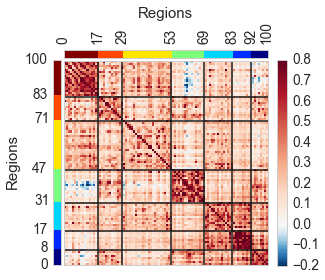

In [14]:

dd=ts.vec2mat(list_conn_sites[5].mean(axis=1))

fig = plt.figure(figsize=(4, 4),dpi=150)
sns.set_context('paper',font_scale=1.7)

vis.mat(hc.ordermat(all_sites,ind_sub),[-0.2,0.8],True,False)
ax = plt.gca()
ax.grid(False)


def show_cluster(ind_sub,lw=1.5,color='w'):
    ax = plt.gca()
    # Use matplotlib directly to emphasize known networks
    networks = np.sort(ind_sub)
    for i, network in enumerate(networks):
        if i and network != networks[i-1]:
            ax.axhline(i, c=color, lw=lw)
            ax.axvline(i-1, c=color, lw=lw)

show_cluster(ind_sub,color='k')

cmap = cm.jet
ax_bar = fig.add_axes([0.085, 0.16, 0.03, 0.71])
ax_bar_top = fig.add_axes([0.124,0.877 , 0.71,0.03])
#bounds = np.linspace(0, 100, 7)
bounds=[0]
for i in range(7,0,-1):
        bounds.append(bounds[-1] + np.sum(ind_sub==i))

norm = mpl.colors.BoundaryNorm(bounds,cmap.N)


#mpl.colorbar.ColorbarBase(ax_bar, cmap=cmap, norm=norm, spacing=np.sort(ind_sub), ticks=bounds ,boundaries=bounds,orientation='vertical')
cmm = mpl.colorbar.ColorbarBase(ax_bar, cmap=cmap, norm=norm, spacing=bounds ,orientation='vertical')
#ax_bar.get_yaxis().set_ticks([])
#ax_bar.grid(False)
ax_bar.set_ylabel('Regions')
ax_bar.yaxis.tick_left()
ax_bar.yaxis.set_label_position('left')


cmap = cm.jet_r
bounds=[0]
for i in range(1,8,1):
        bounds.append(bounds[-1] + np.sum(ind_sub==i))

norm = mpl.colors.BoundaryNorm(bounds,cmap.N)

cmm = mpl.colorbar.ColorbarBase(ax_bar_top, cmap=cmap, norm=norm, spacing=bounds ,orientation='horizontal')
#ax_bar_top.get_xaxis().set_ticks([])
#ax_bar_top.grid(False)
ax_bar_top.set_xlabel('Regions')
ax_bar_top.xaxis.tick_top()
ax_bar_top.xaxis.set_label_position('top')
ll = ax_bar_top.get_xticklabels()
for label in ll:
    label.set_rotation(90)


plt.savefig(main_path + 'figures/matrix_7net_multisite.pdf')
plt.savefig(main_path + 'figures/matrix_7net_multisite.png')

In [13]:
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(256)]

# create the new map
#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds_sub = np.linspace(0, 100, 8)
bounds_sub = np.ceil(bounds_sub)

for i in range(1,len(bounds)):
    idx_t1 = int(np.round(256*(bounds_sub[i-1]/100.)))
    idx_t2 = int(np.round(256*(bounds_sub[i]/100.)))
    print cmap(idx_t1), idx_t1,idx_t2
    for j in range(idx_t1,idx_t2):
        
        if i==7:
            cmaplist[j]=cmap(idx_t2)
        elif i==6:
            cmaplist[j]=cmap(idx_t2)
        elif i==5:
            cmaplist[j]=cmap(idx_t2-15)
        elif i==4:
            cmaplist[j]=cmap(idx_t1+20)
        elif i==1:
            cmaplist[j]=cmap(idx_t1)
        else:
            cmaplist[j]=cmap(idx_t1)
            
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)   
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)



(0.0, 0.0, 0.5, 1.0) 0 38
(0.0, 0.096078431372549025, 1.0, 1.0) 38 74
(0.0, 0.66078431372548996, 1.0, 1.0) 74 110
(0.26249209361163817, 1.0, 0.70524984187223283, 1.0) 110 148
(0.74320050600885468, 1.0, 0.22454142947501621, 1.0) 148 184
(1.0, 0.69789397240377649, 0.0, 1.0) 184 220
(1.0, 0.1750181554103124, 0.0, 1.0) 220 256


In [14]:
fig = plt.figure()

data_dmn = 8-ind_sub#all_sites[hc.order(ind_sub==2),:].mean(axis=0)

#vis.mat(hc.ordermat(rejected ,order),lim_mean_diff,False,False)

nn_map = ts.vec2map(data_dmn,im_ref)
display = plotting.plot_anat(anat_img=anat_template,
                             display_mode='z',
                             cut_coords=[-30,-20,0,20,30,45],
                             annotate=False,
                             draw_cross=False)

display.add_overlay(nn_map,
                    colorbar=False,
                    vmin=0,
                    vmax=7,
                    cmap=cmap)


plt.savefig(main_path + 'figures/map_7net_multisite.pdf')
plt.savefig(main_path + 'figures/map_7net_multisite.png')


NameError: name 'im_ref' is not defined

In [16]:
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(256)]

# create the new map
#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds_sub = np.linspace(0, 100, 8)
bounds_sub = np.ceil(bounds_sub)

for i in range(0,len(cmaplist)):
    if i>128:
        cmaplist[i] = (1.,0.,0.,1.0)
    else:
        cmaplist[i] = (0.,0.,0.,1.0)
    
            
# force the first color entry to be grey

cmap_br = cmap.from_list('Custom cmap', cmaplist, cmap.N)



In [16]:
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(256)]

# create the new map
#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds_sub = np.linspace(0, 100, 3)
bounds_sub = np.ceil(bounds_sub)

for i in range(1,len(bounds)):
    idx_t1 = int(np.round(256*(bounds_sub[i-1]/100.)))
    idx_t2 = int(np.round(256*(bounds_sub[i]/100.)))
    print cmap(idx_t1), idx_t1,idx_t2
    for j in range(idx_t1,idx_t2):
        
        if i==7:
            cmaplist[j]=cmap(idx_t2)
        elif i==6:
            cmaplist[j]=cmap(idx_t2)
        elif i==5:
            cmaplist[j]=cmap(idx_t2-15)
        elif i==4:
            cmaplist[j]=cmap(idx_t1+20)
        elif i==1:
            cmaplist[j]=cmap(idx_t1)
        else:
            cmaplist[j]=cmap(idx_t1)
            
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)   
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

(0.0, 0.0, 0.5, 1.0) 0 128
(0.49019607843137247, 1.0, 0.47754585705249841, 1.0) 128 256


IndexError: index 3 is out of bounds for axis 0 with size 3

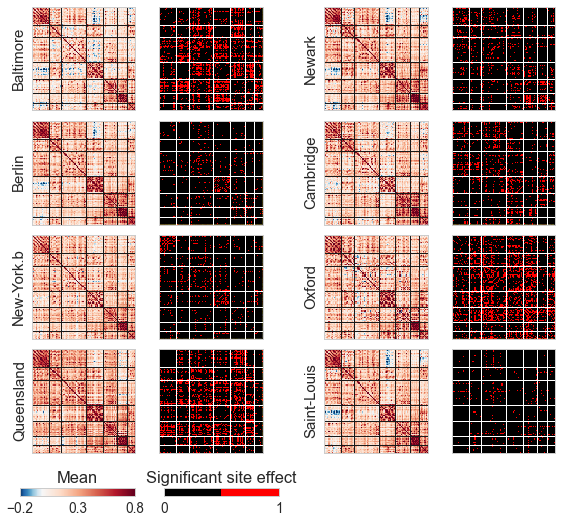

In [17]:
from Proteus.proteus.predic import clustering as hc
from Proteus.proteus.matrix import tseries as ts
from Proteus.proteus.visu import matrix as vis
import matplotlib.gridspec as gridspec
from scipy import stats
import statsmodels.stats.multitest as smm
from matplotlib.pylab import *
import matplotlib.patches as mpatches
from sklearn import linear_model

from nilearn import plotting
reload(vis)
#reload(vis.matrix)
reload(ts)
reload(hc)

def get_stats(conns):
    # compute the mean, std, ...   
    return ts.vec2mat(conns.mean(axis=1)), ts.vec2mat(conns.std(axis=1),val_diag=0)

def gen_fig(list_conn_sites):
    
    all_sites=[]
    all_matrix = []
    for sidx in range(0,len(list_conn_sites)):

            conn_vec = list_conn_sites[sidx]
            if sidx == 0:
                all_sites = conn_vec
            else:
                all_sites = np.hstack((all_sites,conn_vec))

    all_sites = all_sites.mean(axis=1)
    all_sites = ts.vec2mat(all_sites)
    order = hc.hclustering(all_sites,7)
    #ordered_mat = hc.ordermat(all_sites,order)
    #vis.mat(ordered_mat)
    
    site_names = ['Baltimore','Newark','Berlin','Cambridge','New-York.b','Oxford','Queensland','Saint-Louis']
    lim_mean = [-0.2,0.8]
    lim_mean_diff = [0,1]#[-0.3,0.3]
    lim_std  = [0,.3]
    fig = plt.figure(figsize=(8, 8),dpi=150)
    sns.set_context('paper',font_scale=1.7)
    fig.patch.set_facecolor('white')
    grid1 = gridspec.GridSpec(len(list_conn_sites)/2,2, wspace=0.0, hspace=0.0)
    #grid1.update(wspace=0.0, hspace=0.0, bottom=0.0, top=0.5, left=0, right=0)
    grid1.update(wspace=0.15, hspace=0.1, left=0.05, right=1.)
    for sidx in range(0,4):
        
        if sidx > 0:
            conn_vec = list_conn_sites[sidx-1]
            site_mean, site_std = get_stats(conn_vec)
        
        # compare to all other sites
        col_idx = 0
        for site_diff_idx in range(2*sidx,2*sidx+2):
            grid2 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=grid1[sidx,col_idx], wspace=0.001)

            #grid2 = gridspec.GridSpec(len(list_conn_sites), 2, subplot_spec=grid1[sidx], wspace=0.05, hspace=0.0)
            #gs2 = gridspec.GridSpec(len(list_conn_sites), 2)
            site_mean_tmp, site_std_tmp = get_stats(list_conn_sites[site_diff_idx])
            
            if col_idx==1:
                shift_col = 3
            else:
                shift_col = 0
            shift_col = 0
            
            ax1 = plt.subplot(grid2[:,shift_col])
            vis.mat(hc.ordermat(site_mean_tmp,order),lim_mean,False,False)
            show_cluster(order,1,color='k')
            ax1.get_yaxis().set_visible(True)
            ax1.get_yaxis().set_ticks([])
            plt.ylabel(site_names[site_diff_idx])
            #if sidx == 0:
                #plt.title('Mean')
            
           
            ax3 = plt.subplot(grid2[:,shift_col+1])
            vis.mat(hc.ordermat(site_std_tmp,order),lim_std,False,False)
            
            ## difference computation
            
            conn_vec_tmp = []
            
            for k in range(len(list_conn_sites)):
                if k==0:
                    conn_vec_tmp = list_conn_sites[k]
                else:
                    conn_vec_tmp = np.hstack((conn_vec_tmp,list_conn_sites[k]))

            x_=[]
            contrast=[]
            for k in range(0,len(demog_data)):
                tmp_x = sm.tools.add_constant(demog_data[k])
                if k==site_diff_idx:
                    if len(x_)==0:
                        contrast = np.ones(tmp_x.shape[0])
                        x_ = tmp_x
                    else:
                        contrast = np.hstack((contrast,np.ones(tmp_x.shape[0])))
                        x_ = np.vstack((x_,tmp_x))
                else:
                    if len(x_)==0:
                        contrast = np.zeros(tmp_x.shape[0])
                        x_ = tmp_x
                    else:
                        contrast = np.hstack((contrast,np.zeros(tmp_x.shape[0])))
                        x_ = np.vstack((x_,tmp_x))
                        
            #np.hstack((np.ones(x_1.shape[0]),np.zeros(x_2.shape[0])))
            #x_ = np.vstack((x_1,x_2))
            #contrast = np.hstack((np.ones(x_1.shape[0]),np.zeros(x_2.shape[0])))
            #print contrast.shape,x_.shape
            x_ = np.hstack((contrast[:,np.newaxis],x_))
            pval = []
            #print conn_vec_tmp.shape
            for nn in range(conn_vec_tmp.shape[0]):
                y_ = conn_vec_tmp[nn,:]
                glm_ = sm.GLM(y_, x_)
                res = glm_.fit()
                #print(res.summary())
                pval.append(res.pvalues[0])
            pval = np.array(pval)
            #conn_vec_tmp = detrended_conn[site_diff_idx]
            #t,pval = stats.ttest_ind(detrended_conn[sidx-1],conn_vec_tmp, axis=0, equal_var = False)
            rejected , pvaluecorrected = smm.multipletests(pval, alpha=0.05, method='fdr_bh')[:2]
            all_matrix.append(rejected)
            rejected = ts.vec2mat(rejected,0)
            #print conn_vec_tmp.shape
            site_mean_tmp, site_std_tmp = get_stats(conn_vec_tmp)
            #site_mean, site_std = get_stats(detrended_conn[sidx-1].T)
            ax3 = plt.subplot(grid2[:,shift_col+1])
            #vis.mat(hc.ordermat(np.abs(site_mean - site_mean_tmp),order),lim_mean,False,False)
            vis.mat(hc.ordermat(rejected ,order),lim_mean_diff,False,False,cm=cmap_br)
            show_cluster(order,1)
            #if sidx == 0:
                #plt.title('Significant site effect')
            
                #vis.mat(hc.ordermat(rejected ,order),lim_mean_diff,False,False)
            #print((site_mean - site_mean_tmp).min(), (site_mean - site_mean_tmp).max())
            
            col_idx = 1
    

    # include the color bars 2
    lim = lim_mean
    cmap = vis.get_cmap(site_mean, lim)
    ax_bar = fig.add_axes([0.05, 0.05, 0.20, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap, lim,3)
    plt.title('Mean')

    '''
    # include the color bars 3
    lim = lim_mean_diff
    cmap = cm.gray
    ax_bar = fig.add_axes([0.38, 0.05, 0.20, 0.015])
    bounds = np.linspace(lim[0], lim[1], 3)
    norm = mpl.colors.BoundaryNorm(bounds,cmap.N)
    mpl.colorbar.ColorbarBase(ax_bar, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds ,boundaries=bounds,orientation='horizontal')
    #vis.color_bar_horizontal(ax_bar, cmap, lim,3)
    '''
    #red_patch = mpatches.Patch(color='red',label='Mean')
    #plt.legend(bbox_to_anchor=(3.5,3.),handles=[red_patch])
    ax_bar = fig.add_axes([0.3, 0.05, 0.20, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap_br, [0,1],2)
    #ax_bar.locator_params(tight=True,nbins=4)
    #plt.locator_params(tight=True,nbins=4)
    plt.title('Significant site effect')
    #fig.tight_layout()
    plt.savefig(main_path + 'figures/connectome_multisite2.pdf')
    plt.savefig(main_path + 'figures/connectome_multisite2.png')
    
    return all_matrix
                

all_matrix = gen_fig(list_conn_sites)

site_mean, site_std = get_stats(conns_stack)
#vis.matrix.mat(site_mean,[-1,1.3])
#vis.matrix.mat(site_mean)



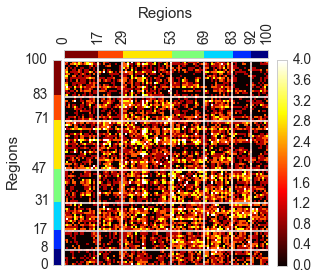

In [18]:
reload(vis)
dd = []
for i in range(len(all_matrix)):
    if i==0:
        dd = all_matrix[i][:,np.newaxis]
    else:
        dd = np.hstack((dd,all_matrix[i][:,np.newaxis]))
    
dd = ts.vec2mat(dd.sum(axis=1))

fig = plt.figure(figsize=(4, 4),dpi=150)
sns.set_context('paper',font_scale=1.7)
vis.mat(hc.ordermat(dd,ind_sub),[0,4],True,False)
ax = plt.gca()
ax.grid(False)

show_cluster(ind_sub)

cmap = plt.cm.jet
ax_bar = fig.add_axes([0.085, 0.16, 0.03, 0.71])
ax_bar_top = fig.add_axes([0.124,0.877 , 0.71,0.03])
#bounds = np.linspace(0, 100, 7)
bounds=[0]
for i in range(7,0,-1):
        bounds.append(bounds[-1] + np.sum(ind_sub==i))

norm = mpl.colors.BoundaryNorm(bounds,cmap.N)
cmm = mpl.colorbar.ColorbarBase(ax_bar, cmap=cmap, norm=norm, spacing=bounds ,orientation='vertical')
#ax_bar.get_yaxis().set_ticks([])
#ax_bar.grid(False)
ax_bar.set_ylabel('Regions')
ax_bar.yaxis.tick_left()
ax_bar.yaxis.set_label_position('left')

cmap = plt.cm.jet_r
bounds=[0]
for i in range(1,8,1):
        bounds.append(bounds[-1] + np.sum(ind_sub==i))

norm = mpl.colors.BoundaryNorm(bounds,cmap.N)
mpl.colorbar.ColorbarBase(ax_bar_top, cmap=cmap, norm=norm, spacing=bounds ,orientation='horizontal')
#ax_bar_top.get_xaxis().set_ticks([])
#ax_bar_top.grid(False)
ax_bar_top.set_xlabel('Regions')
ax_bar_top.xaxis.tick_top()
ax_bar_top.xaxis.set_label_position('top')
ll = ax_bar_top.get_xticklabels()
for label in ll:
    label.set_rotation(90)

plt.savefig(main_path + 'figures/matrix_signif_conn_multisite.png')

0.844705882353 0.938397367525
0.931666666667 0.979113828362
1.1625 1.07715385004
1.148125 1.08567213484
1.26857142857 1.05187490527
0.962222222222 0.959580669735
0.78375 0.840824558098
[[  1.00000000e+00   1.66719920e-02   1.94890135e-23   1.68426381e-17
    5.49751931e-31   2.80819152e-03   1.03857149e-01]
 [  1.66719920e-02   1.00000000e+00   1.38140227e-10   3.67433347e-08
    4.88007473e-17   4.74393299e-01   3.21423766e-04]
 [  1.94890135e-23   1.38140227e-10   1.00000000e+00   6.80788051e-01
    2.99056344e-03   2.77719191e-07   6.27693285e-24]
 [  1.68426381e-17   3.67433347e-08   6.80788051e-01   1.00000000e+00
    2.08010917e-03   9.93834149e-06   3.38306695e-19]
 [  5.49751931e-31   4.88007473e-17   2.99056344e-03   2.08010917e-03
    1.00000000e+00   9.01379289e-13   2.61726357e-31]
 [  2.80819152e-03   4.74393299e-01   2.77719191e-07   9.93834149e-06
    9.01379289e-13   1.00000000e+00   4.61926005e-05]
 [  1.03857149e-01   3.21423766e-04   6.27693285e-24   3.38306695e-19
 

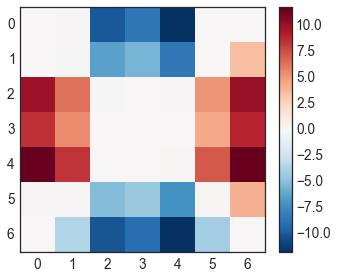

In [72]:
for i in range(1,8): print dd[ind_sub==i,:].mean(),dd[ind_sub==i,:].std()

comp_matrix = np.zeros((7,7))
pval_matrix = np.zeros((7,7))
for i in range(1,8):
    for j in range(1,8):
        ttest,pval= scipy.stats.ttest_ind(dd[ind_sub==i,:].flatten().T,dd[ind_sub==j,:].flatten().T,equal_var=False)
        #if rejected==True:
        comp_matrix[i-1,j-1] = ttest
        pval_matrix[i-1,j-1] = pval
        #    print i,j, ttest,pval


rejected , pvaluecorrected = smm.multipletests(pval_matrix.flatten(), alpha=0.05, method='fdr_bh')[:2]
rejected = np.reshape(rejected,(7,7))
print pval_matrix
print rejected,pvaluecorrected
vis.mat(comp_matrix*(pval_matrix<(0.05/49)))
plt.grid(False)

49

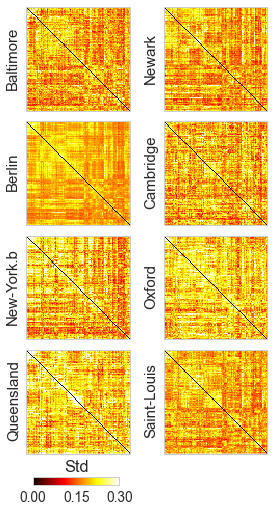

In [20]:
from Proteus.proteus.predic import clustering as hc
from Proteus.proteus.matrix import tseries as ts
from Proteus.proteus.visu import matrix as vis
import matplotlib.gridspec as gridspec
from scipy import stats
import statsmodels.stats.multitest as smm
from matplotlib.pylab import *

reload(vis)
#reload(vis.matrix)
reload(ts)
reload(hc)

def get_stats(conns):
    # compute the mean, std, ...   
    return ts.vec2mat(conns.mean(axis=1)), ts.vec2mat(conns.std(axis=1),val_diag=0)

def gen_fig(list_conn_sites):
    
    for sidx in range(0,len(list_conn_sites)):

        conn_vec = list_conn_sites[sidx]
        site_mean, site_std = get_stats(conn_vec)
        #print(site_mean.min(),site_mean.max(), site_std.min(),site_std.max())
        if sidx == 0:
            all_sites = site_mean
        else:
            all_sites = all_sites + site_mean
            
        all_sites = all_sites / len(list_conn_sites)

    order = hc.hclustering(all_sites, 100)
    #ordered_mat = hc.ordermat(all_sites,order)
    #vis.mat(ordered_mat)
    
    site_names = ['Baltimore','Newark','Berlin','Cambridge','New-York.b','Oxford','Queensland','Saint-Louis']
    lim_mean = [-0.8,0.8]
    lim_mean_diff = [0,1]#[-0.3,0.3]
    lim_std  = [0,.3]
    fig = plt.figure(figsize=(4, 8),dpi=150)
    sns.set_context('paper',font_scale=1.7)
    fig.patch.set_facecolor('white')
    grid1 = gridspec.GridSpec(len(list_conn_sites)/2,2, wspace=0.0, hspace=0.0)
    #grid1.update(wspace=0.0, hspace=0.0, bottom=0.0, top=0.5, left=0, right=0)
    grid1.update(wspace=0.01, hspace=0.1, left=0.05, right=1)
    for sidx in range(0,4):
        
        if sidx > 0:
            conn_vec = list_conn_sites[sidx-1]
            site_mean, site_std = get_stats(conn_vec)
        
        # compare to all other sites
        col_idx = 0
        for site_diff_idx in range(2*sidx,2*sidx+2):
            grid2 = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=grid1[sidx,col_idx], wspace=0.05)

            #grid2 = gridspec.GridSpec(len(list_conn_sites), 2, subplot_spec=grid1[sidx], wspace=0.05, hspace=0.0)
            #gs2 = gridspec.GridSpec(len(list_conn_sites), 2)
            site_mean_tmp, site_std_tmp = get_stats(list_conn_sites[site_diff_idx])
            
            if col_idx==1:
                shift_col = 3
            else:
                shift_col = 0
            shift_col = 0
            
            # include the last std at the end of the 
            
            ax2 = plt.subplot(grid2[0])
            vis.mat(hc.ordermat(site_std_tmp,order),lim_std,False,False)
            ax2.get_yaxis().set_visible(True)
            ax2.get_yaxis().set_ticks([])
            plt.ylabel(site_names[site_diff_idx])

            col_idx = 1

    
    from sklearn import linear_model
    

    
    
    # include the color bars 1
    lim = lim_std
    cmap = vis.get_cmap(site_std, lim)
    ax_bar = fig.add_axes([0.13, 0.07, 0.30, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap, lim,3)
    plt.title('Std')
    
    

    
    #fig.tight_layout()
    plt.savefig(main_path + 'figures/connectome_std_multisite2.pdf')
    plt.savefig(main_path + 'figures/connectome_std_multisite2.png')
                

gen_fig(list_conn_sites)

site_mean, site_std = get_stats(conns_stack)
#vis.matrix.mat(site_mean,[-1,1.3])
#vis.matrix.mat(site_mean)



## Matrix brain

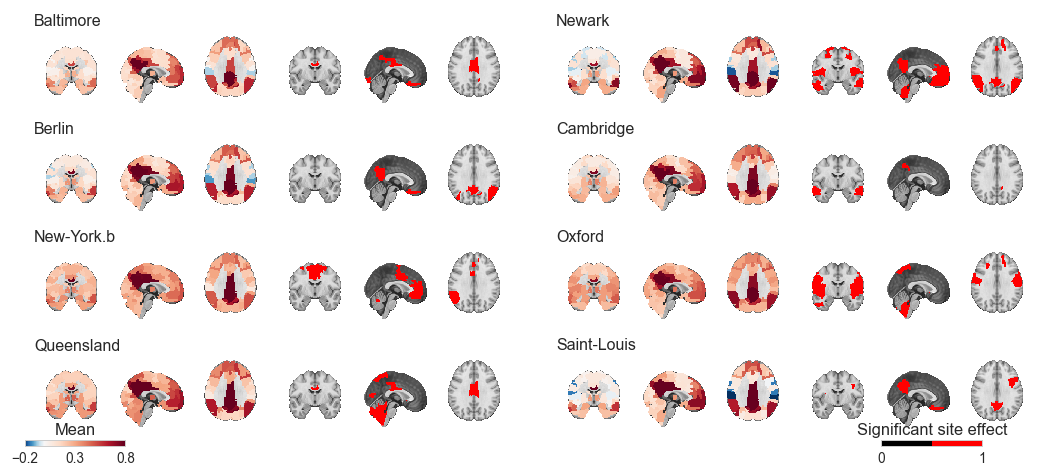

In [19]:
from Proteus.proteus.predic import clustering as hc
from Proteus.proteus.matrix import tseries as ts
from Proteus.proteus.visu import matrix as vis
import matplotlib.gridspec as gridspec
from scipy import stats
import statsmodels.stats.multitest as smm
from matplotlib.pylab import *

import copy
import nilearn
from nilearn import plotting
import nibabel as nib

reload(vis)
#reload(vis.matrix)
reload(ts)
reload(hc)

def mapvec(v,partition):
    new_map = copy.deepcopy(partition)
    im = new_map.get_data()
    
    part = partition.get_data()  
    for i in range(len(v)):
        idxs = np.where(part==(i+1))
        im[idxs] = v[i]
    return new_map

def get_stats(conns):
    # compute the mean, std, ...   
    return ts.vec2mat(conns.mean(axis=1)), ts.vec2mat(conns.std(axis=1),val_diag=0)

def gen_fig(list_conn_sites):
    anat_template = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/white_template.nii.gz')
    selected_network_idx = 0
    cutcoor = (0, -7,30)
    
    all_dmn=[]
    
    im_ref = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/Multisite/figures/network_basc.mnc')
    im_ref = nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())
    
    for sidx in range(0,len(list_conn_sites)):

        conn_vec = list_conn_sites[sidx]
        site_mean, site_std = get_stats(conn_vec)
        #print(site_mean.min(),site_mean.max(), site_std.min(),site_std.max())
        if sidx == 0:
            all_sites = site_mean
        else:
            all_sites = all_sites + site_mean
            
        all_sites = all_sites / len(list_conn_sites)

    order = hc.hclustering(all_sites, 100)
    #ordered_mat = hc.ordermat(all_sites,order)
    #vis.mat(ordered_mat)
    
    site_names = ['Baltimore','Newark','Berlin','Cambridge','New-York.b','Oxford','Queensland','Saint-Louis']
    lim_mean = [-0.2,0.8]
    lim_mean_diff = [0,1]#[-0.3,0.3]
    lim_std  = [0,.3]
    fig = plt.figure(figsize=(14, 6),dpi=300)
    sns.set_context('paper',font_scale=1.7)
    fig.patch.set_facecolor('white')
    grid1 = gridspec.GridSpec(4,2, wspace=0.0, hspace=0.0)
    #grid1.update(wspace=0.0, hspace=0.0, bottom=0.0, top=0.5, left=0, right=0)
    grid1.update(wspace=0.1, hspace=0.001, left=0.01, right=1., bottom=0.0,top=1.)
    for sidx in range(0,4):
        
        if sidx > 0:
            conn_vec = list_conn_sites[sidx-1]
            site_mean, site_std = get_stats(conn_vec)
        
        # compare to all other sites
        col_idx = 0
        for site_diff_idx in range(2*sidx,2*sidx+2):
            grid2 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=grid1[sidx,col_idx], wspace=0.05,hspace=0.001)

            #grid2 = gridspec.GridSpec(len(list_conn_sites), 2, subplot_spec=grid1[sidx], wspace=0.05, hspace=0.0)
            #gs2 = gridspec.GridSpec(len(list_conn_sites), 2)
            site_mean_tmp, site_std_tmp = get_stats(list_conn_sites[site_diff_idx])
            
            if col_idx==1:
                shift_col = 3
            else:
                shift_col = 0
            shift_col = 0
            
            nn_map = mapvec(site_mean_tmp[selected_network_idx,:],im_ref)
            ax1 = plt.subplot(grid2[:,shift_col])
            
            display = plotting.plot_anat(anat_img=anat_template,
                                         display_mode='ortho',
                                         cut_coords=cutcoor,
                                         annotate=False,
                                         draw_cross=False,
                                         axes=ax1)

            display.add_overlay(nn_map,
                                cmap=vis.get_cmap(nn_map.get_data()),
                                vmin=lim_mean[0],
                                vmax=lim_mean[1])
            
            
            #ax1.get_yaxis().set_visible(True)
            #ax1.get_yaxis().set_ticks([])
            #plt.ylabel(site_names[site_diff_idx])
            #ax1.text(-0.1,0.6,site_names[site_diff_idx],verticalalignment='center',rotation='vertical',size=16)
            ax1.text(0,1.,site_names[site_diff_idx],horizontalalignment='left',verticalalignment='top',size=16)
            
            #if sidx == 0:
             #   plt.title('Mean')
            '''
            # include the last std at the end of the 
            nn_map = mapvec(site_std_tmp[selected_network_idx,:],im_ref)
            ax2 = plt.subplot(grid2[:,shift_col+1])
            display = plotting.plot_anat(anat_img=anat_template,
                                         display_mode='ortho',
                                         cut_coords=cutcoor,
                                         annotate=False,
                                         draw_cross=False,
                                         axes=ax2)

            display.add_overlay(nn_map,
                                cmap=plotting.cm.black_red,
                                vmin=lim_std[0],
                                vmax=lim_std[1])
            
            #vis.mat(hc.ordermat(site_std_tmp,order),lim_std,False,False)
            #plt.ylabel('std')
            if sidx == 0:
                plt.title('Std')
           
           
            ax3 = plt.subplot(grid2[:,shift_col+1])
            
            display = plotting.plot_anat(anat_img=anat_template,
                                         display_mode='ortho',
                                         cut_coords=cutcoor,
                                         annotate=False,
                                         draw_cross=False,
                                         axes=ax3)

            display.add_overlay(nn_map,
                                cmap=plotting.cm.black_red,
                                vmin=lim_std[0],
                                vmax=lim_std[1])
            
            
            '''
            ## difference computation
            
            conn_vec_tmp = []
            
            for k in range(len(list_conn_sites)):
                if k==0:
                    conn_vec_tmp = list_conn_sites[k]
                else:
                    conn_vec_tmp = np.hstack((conn_vec_tmp,list_conn_sites[k]))

            x_=[]
            contrast=[]
            for k in range(0,len(demog_data)):
                tmp_x = sm.tools.add_constant(demog_data[k])
                if k==site_diff_idx:
                    if len(x_)==0:
                        contrast = np.ones(tmp_x.shape[0])
                        x_ = tmp_x
                    else:
                        contrast = np.hstack((contrast,np.ones(tmp_x.shape[0])))
                        x_ = np.vstack((x_,tmp_x))
                else:
                    if len(x_)==0:
                        contrast = np.zeros(tmp_x.shape[0])
                        x_ = tmp_x
                    else:
                        contrast = np.hstack((contrast,np.zeros(tmp_x.shape[0])))
                        x_ = np.vstack((x_,tmp_x))
                        
            x_ = np.hstack((contrast[:,np.newaxis],x_))
            pval = []
            #print conn_vec_tmp.shape
            for nn in range(conn_vec_tmp.shape[0]):
                y_ = conn_vec_tmp[nn,:]
                glm_ = sm.GLM(y_, x_)
                res = glm_.fit()
                #print(res.summary())
                pval.append(res.pvalues[0])
            pval = np.array(pval)
            rejected , pvaluecorrected = smm.multipletests(pval, alpha=0.05, method='fdr_bh')[:2]
            rejected = ts.vec2mat(rejected,0)
            #print conn_vec_tmp.shape
            site_mean_tmp, site_std_tmp = get_stats(conn_vec_tmp)
            ax3 = plt.subplot(grid2[:,shift_col+1])
            #vis.mat(hc.ordermat(rejected ,order),lim_mean_diff,False,False)
            
            all_dmn.append(rejected[selected_network_idx,:])
            nn_map = mapvec(rejected[selected_network_idx,:],im_ref)
            display = plotting.plot_anat(anat_img=anat_template,
                                         display_mode='ortho',
                                         cut_coords=cutcoor,
                                         annotate=False,
                                         draw_cross=False,
                                         axes=ax3)

            display.add_overlay(nn_map,
                                cmap=plotting.cm.bwr,
                                vmin=lim_std[0],
                                vmax=lim_std[1])
                                
                                
            
            #if sidx == 0:
             #   plt.title('Significant site effect')
            
            col_idx = 1
            
            

    
    from sklearn import linear_model
    

    # include the color bars 2
    lim = lim_mean
    cmap = vis.get_cmap(site_mean, lim)
    ax_bar = fig.add_axes([0.0, 0.0, 0.10, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap, lim,3)
    plt.title('Mean')
    
    

    # include the color bars 3
    '''
    lim = lim_mean_diff
    cmap = plotting.cm.bwr
    ax_bar = fig.add_axes([0.34, 0.0, 0.10, 0.015])
    bounds = np.linspace(lim[0], lim[1], 3)
    norm = mpl.colors.BoundaryNorm(bounds,cmap.N)
    mpl.colorbar.ColorbarBase(ax_bar, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds ,boundaries=bounds,orientation='horizontal')
    '''
    import matplotlib.patches as mpatches
    #patch_red = mpatches.Patch(color='red',label='Signifficant diff')
    #rec1 = mpatches.Rectangle((0,10),10,1,color='red')
    #patch_red = mpatches.PathPath(facecolor='red')
    #ax_bar = fig.add_subplot(111)
    #red_patch = mpatches.Patch(color='red',label='Signifficant diff')
    #plt.legend(bbox_to_anchor=(10.,3.),handles=[red_patch])
    ax_bar = fig.add_axes([0.85, 0.0, 0.10, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap_br, [0,1],2)
    #ax_bar.locator_params(tight=True,nbins=4)
    #plt.locator_params(tight=True,nbins=4)
    plt.title('Significant site effect')
    
    #plt.legend(bbox_to_anchor=(0.5, 0.25), mode='expand', borderaxespad=0.)
    #ax_bar.add_patch(rec1)
    #ax_bar.text(0,1.,'sdkan',horizontalalignment='left',verticalalignment='top',size=16)
    
    #vis.color_bar_horizontal(ax_bar, cmap, lim,3)
    
    #ax_bar.locator_params(tight=True,nbins=4)
    #plt.locator_params(tight=True,nbins=4)
    #plt.title('Significant diff')
    #fig.tight_layout()
    plt.savefig(main_path + 'figures/dmn_multisite2.pdf')
    plt.savefig(main_path + 'figures/dmn_multisite2.png')
    return all_dmn
                

all_dmn=gen_fig(list_conn_sites)

site_mean, site_std = get_stats(conns_stack)
#vis.matrix.mat(site_mean,[-1,1.3])
#vis.matrix.mat(site_mean)



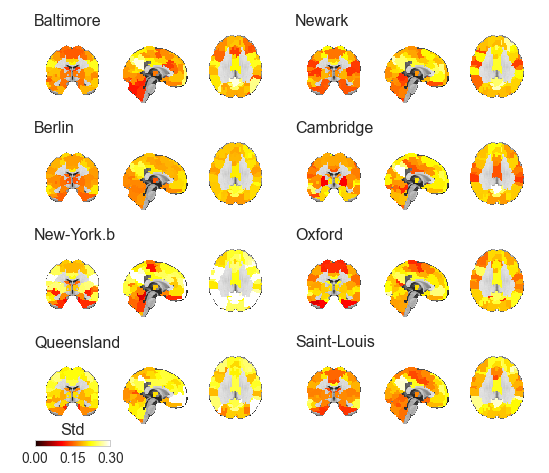

In [21]:
from Proteus.proteus.predic import clustering as hc
from Proteus.proteus.matrix import tseries as ts
from Proteus.proteus.visu import matrix as vis
import matplotlib.gridspec as gridspec
from scipy import stats
import statsmodels.stats.multitest as smm
from matplotlib.pylab import *

import copy
import nilearn
from nilearn import plotting
import nibabel as nib

reload(vis)
#reload(vis.matrix)
reload(ts)
reload(hc)

def mapvec(v,partition):
    new_map = copy.deepcopy(partition)
    im = new_map.get_data()
    
    part = partition.get_data()  
    for i in range(len(v)):
        idxs = np.where(part==(i+1))
        im[idxs] = v[i]
    return new_map

def get_stats(conns):
    # compute the mean, std, ...   
    return ts.vec2mat(conns.mean(axis=1)), ts.vec2mat(conns.std(axis=1),val_diag=0)

def gen_fig(list_conn_sites):
    anat_template = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/white_template.nii.gz')
    selected_network_idx = 0
    cutcoor = (0, -7,30)
    
    all_dmn=[]
    
    im_ref = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/Multisite/figures/network_basc.mnc')
    im_ref = nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())
    
    for sidx in range(0,len(list_conn_sites)):

        conn_vec = list_conn_sites[sidx]
        site_mean, site_std = get_stats(conn_vec)
        #print(site_mean.min(),site_mean.max(), site_std.min(),site_std.max())
        if sidx == 0:
            all_sites = site_mean
        else:
            all_sites = all_sites + site_mean
            
        all_sites = all_sites / len(list_conn_sites)

    order = hc.hclustering(all_sites, 100)
    #ordered_mat = hc.ordermat(all_sites,order)
    #vis.mat(ordered_mat)
    
    site_names = ['Baltimore','Newark','Berlin','Cambridge','New-York.b','Oxford','Queensland','Saint-Louis']
    lim_mean = [-0.2,0.8]
    lim_mean_diff = [0,1]#[-0.3,0.3]
    lim_std  = [0,.3]
    fig = plt.figure(figsize=(7, 6),dpi=150)
    sns.set_context('paper',font_scale=1.7)
    fig.patch.set_facecolor('white')
    grid1 = gridspec.GridSpec(4,2, wspace=0.0, hspace=0.0)
    #grid1.update(wspace=0.0, hspace=0.0, bottom=0.0, top=0.5, left=0, right=0)
    grid1.update(wspace=0.1, hspace=0.001, left=0.01, right=1., bottom=0.01,top=1.)
    for sidx in range(0,4):
        
        if sidx > 0:
            conn_vec = list_conn_sites[sidx-1]
            site_mean, site_std = get_stats(conn_vec)
        
        # compare to all other sites
        col_idx = 0
        for site_diff_idx in range(2*sidx,2*sidx+2):
            grid2 = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=grid1[sidx,col_idx], wspace=0.05,hspace=0.001)

            #grid2 = gridspec.GridSpec(len(list_conn_sites), 2, subplot_spec=grid1[sidx], wspace=0.05, hspace=0.0)
            #gs2 = gridspec.GridSpec(len(list_conn_sites), 2)
            site_mean_tmp, site_std_tmp = get_stats(list_conn_sites[site_diff_idx])
            
            
            if col_idx==1:
                shift_col = 3
            else:
                shift_col = 0
            shift_col = 0
            
            
            # include the last std at the end of the 
            all_dmn.append(site_std_tmp[selected_network_idx,:])
            nn_map = mapvec(site_std_tmp[selected_network_idx,:],im_ref)
            ax2 = plt.subplot(grid2[0])
            ax2.text(0,1.,site_names[site_diff_idx],horizontalalignment='left',verticalalignment='top',size=16)
            display = plotting.plot_anat(anat_img=anat_template,
                                         display_mode='ortho',
                                         cut_coords=cutcoor,
                                         annotate=False,
                                         draw_cross=False,
                                         axes=ax2)

            display.add_overlay(nn_map,
                                cmap=plotting.cm.black_red,
                                vmin=lim_std[0],
                                vmax=lim_std[1])
            
            #vis.mat(hc.ordermat(site_std_tmp,order),lim_std,False,False)
            #plt.ylabel('std')
            #if sidx == 0:
            #    plt.title('Std')
           
            
            col_idx = 1
            
            

    
    
    
    
    # include the color bars 1
    lim = lim_std
    cmap = vis.get_cmap(site_std, lim)
    ax_bar = fig.add_axes([0.01, 0.0, 0.15, 0.015])
    vis.color_bar_horizontal(ax_bar, cmap, lim,3)
    plt.title('Std')

    
    #fig.tight_layout()
    plt.savefig(main_path + 'figures/dmn_stdmultisite.pdf')
    plt.savefig(main_path + 'figures/dmn_stdmultisite.png')
    return all_dmn
                

all_std_dmn=gen_fig(list_conn_sites)

site_mean, site_std = get_stats(conns_stack)
#vis.matrix.mat(site_mean,[-1,1.3])
#vis.matrix.mat(site_mean)



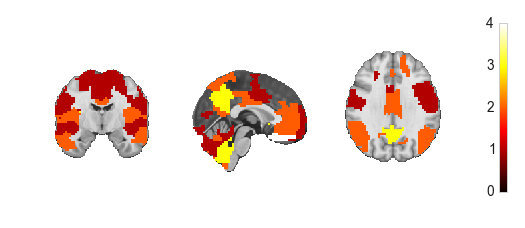

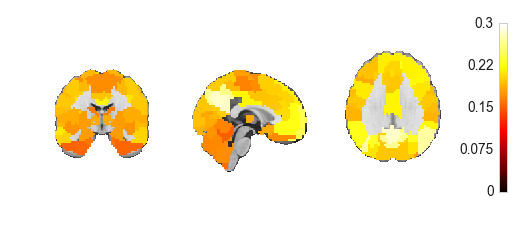

In [903]:
im_ref = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/Multisite/figures/network_basc.mnc')
im_ref = nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())
anat_template = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/white_template.nii.gz')

cutcoor=(0,-7,30)
plt.figure()
for i in range(8):
    if i==0:
        dd = all_dmn[i][:,np.newaxis]
    else:
        dd = np.hstack((dd,all_dmn[i][:,np.newaxis]))

nn_map = ts.vec2map(dd.sum(axis=1),im_ref)
display = plotting.plot_anat(anat_img=anat_template,
                             display_mode='ortho',
                             cut_coords=cutcoor,
                             annotate=False,
                             draw_cross=False)

display.add_overlay(nn_map,
                    colorbar=True,
                    vmin=0,
                    cmap=plotting.cm.black_red)

plt.savefig(main_path + 'figures/dmn_signif_conn_multisite.png')

plt.figure()

for i in range(8):
    if i==0:
        dd = all_std_dmn[i][:,np.newaxis]
    else:
        dd = np.hstack((dd,all_std_dmn[i][:,np.newaxis]))

nn_map = ts.vec2map(dd.mean(axis=1),im_ref)
display = plotting.plot_anat(anat_img=anat_template,
                             display_mode='ortho',
                             cut_coords=cutcoor,
                             annotate=False,
                             draw_cross=False)

display.add_overlay(nn_map,
                    colorbar=True,
                    cmap=plotting.cm.black_red,
                    vmin=0.,
                    vmax=.3)

plt.savefig(main_path + 'figures/dmn_meanstd_conn_multisite.png')

In [245]:
np.min(dd.mean(axis=1))

0.0

In [158]:
for i in range(8):
    if i==0:
        dd = all_dmn[i][:,np.newaxis]
    else:
        dd = np.hstack((dd,all_dmn[i][:,np.newaxis]))
dd.mean(axis=1).shape

(100,)

## make box plot of the variance

In [22]:
from Proteus.proteus.predic import clustering as hc
from Proteus.proteus.matrix import tseries as ts
from Proteus.proteus.visu import matrix as vis
import matplotlib.gridspec as gridspec
from scipy import stats
import statsmodels.stats.multitest as smm
from matplotlib.pylab import *

import copy
import nilearn
from nilearn import plotting
import nibabel as nib

reload(vis)
#reload(vis.matrix)
reload(ts)
reload(hc)

def mapvec(v,partition):
    new_map = copy.deepcopy(partition)
    im = new_map.get_data()
    
    part = partition.get_data()  
    for i in range(len(v)):
        idxs = np.where(part==(i+1))
        im[idxs] = v[i]
    return new_map

def get_stats(conns):
    # compute the mean, std, ...   
    return ts.vec2mat(conns.mean(axis=1)), ts.vec2mat(conns.std(axis=1),val_diag=0)

def gen_fig(list_conn_sites):
    anat_template = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/white_template.nii.gz')
    selected_network_idx = 0
    cutcoor = (0, 0,30)
    
    im_ref = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/Multisite/figures/network_basc.mnc')
    im_ref = nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())
    
    for sidx in range(0,len(list_conn_sites)):

        conn_vec = list_conn_sites[sidx]
        site_mean, site_std = get_stats(conn_vec)
        #print(site_mean.min(),site_mean.max(), site_std.min(),site_std.max())
        if sidx == 0:
            all_sites = site_mean
        else:
            all_sites = all_sites + site_mean
            
        all_sites = all_sites / len(list_conn_sites)

    order = hc.hclustering(all_sites, 100)
    #ordered_mat = hc.ordermat(all_sites,order)
    #vis.mat(ordered_mat)
    
    site_names = ['Baltimore','Newark','Berlin','Cambridge','New-York.b','Oxford','Queensland','Saint-Louis']
    lim_mean = [-0.8,0.8]
    lim_mean_diff = [0,1]#[-0.3,0.3]
    lim_std  = [0,.3]
    fig = plt.figure(figsize=(16, 16),dpi=150)
    sns.set_context('paper',font_scale=1.7)
    fig.patch.set_facecolor('white')
    grid1 = gridspec.GridSpec(4,2, wspace=0.0, hspace=0.0)
    #grid1.update(wspace=0.0, hspace=0.0, bottom=0.0, top=0.5, left=0, right=0)
    grid1.update(wspace=0.1, hspace=0.01, left=0.01, right=0.48, bottom=0.7,top=1.)
    
    all_rejected = np.array([])
    all_avg = np.array([])
    
    for sidx in range(0,len(list_conn_sites)):
        
        if sidx > 0:
            conn_vec = list_conn_sites[sidx-1]
            site_mean, site_std = get_stats(conn_vec)
        
        # compare to all other sites
        #grid2 = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=grid1[sidx,col_idx], wspace=0.05,hspace=0.01)

        #grid2 = gridspec.GridSpec(len(list_conn_sites), 2, subplot_spec=grid1[sidx], wspace=0.05, hspace=0.0)
        #gs2 = gridspec.GridSpec(len(list_conn_sites), 2)
        site_mean_tmp, site_std_tmp = get_stats(list_conn_sites[sidx])


        ## difference computation
        
        conn_vec_tmp = []

        for k in range(len(list_conn_sites)):
            if k==0:
                conn_vec_tmp = list_conn_sites[k]
            else:
                conn_vec_tmp = np.hstack((conn_vec_tmp,list_conn_sites[k]))

        x_=[]
        contrast=[]
        for k in range(0,len(demog_data)):
            tmp_x = sm.tools.add_constant(demog_data[k])
            if k==sidx:
                if len(x_)==0:
                    contrast = np.ones(tmp_x.shape[0])
                    x_ = tmp_x
                else:
                    contrast = np.hstack((contrast,np.ones(tmp_x.shape[0])))
                    x_ = np.vstack((x_,tmp_x))
            else:
                if len(x_)==0:
                    contrast = np.zeros(tmp_x.shape[0])
                    x_ = tmp_x
                else:
                    contrast = np.hstack((contrast,np.zeros(tmp_x.shape[0])))
                    x_ = np.vstack((x_,tmp_x))

        x_ = np.hstack((contrast[:,np.newaxis],x_))
        pval = []
        #print conn_vec_tmp.shape
        for nn in range(conn_vec_tmp.shape[0]):
            y_ = conn_vec_tmp[nn,:]
            glm_ = sm.GLM(y_, x_)
            res = glm_.fit()
            #print(res.summary())
            pval.append(res.pvalues[0])
        pval = np.array(pval)
        rejected , pvaluecorrected = smm.multipletests(pval, alpha=0.05, method='fdr_bh')[:2]
        if len(all_rejected)==0:
            all_rejected = rejected
        else:
            all_rejected = np.vstack((all_rejected,rejected))
        
                    
    return all_rejected 
    
    
                

all_rejected = gen_fig(list_conn_sites)

site_mean, site_std = get_stats(conns_stack)
#vis.matrix.mat(site_mean,[-1,1.3])
#vis.matrix.mat(site_mean)



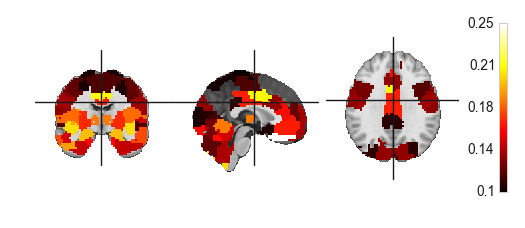

In [78]:
anat_template = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/white_template.nii.gz')
im_ref = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/Multisite/figures/network_basc.mnc')
im_ref = nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())
    
var_sources = ts.vec2mat(all_rejected.mean(axis=0),0).mean(axis=0)

nn_map = mapvec(var_sources,im_ref)
display = plotting.plot_anat(anat_img=anat_template,
                             display_mode='ortho',
                             cut_coords=(0,-7,30),
                             annotate=False,
                             draw_cross=True)

display.add_overlay(nn_map,
                    colorbar=True,
                    threshold=0.1,
                    cmap=cm.hot)


plt.savefig(main_path + 'figures/alldiff_multisite.png')

## 7 networks variance areas

(100, 100)


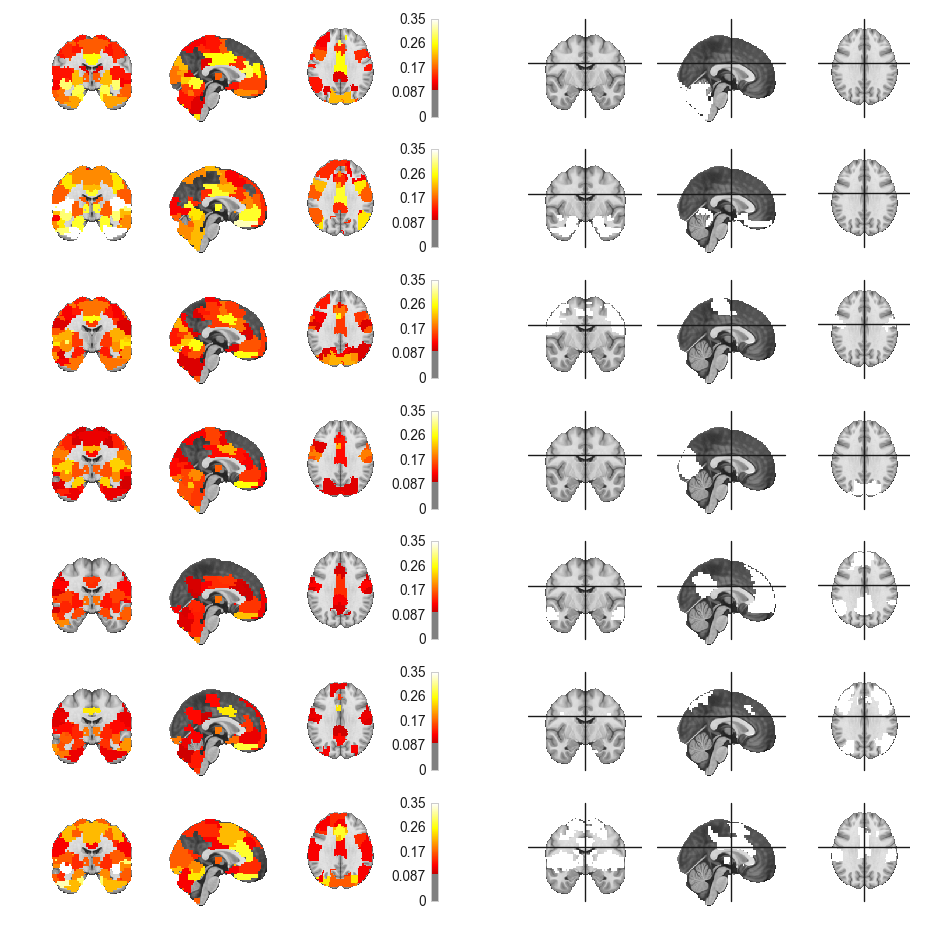

In [77]:
reload(ts)

fig=plt.figure()
im_ref = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/Multisite/figures/network_basc.mnc')
im_ref = nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())

im_net7 = nib.load('/Users/christian/data/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale007.nii.gz')
#im_ref = nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())

var_sources = ts.vec2mat(all_rejected.mean(axis=0),0)
print var_sources.shape

#tmp_img = ts.vec2map(var_sources,im_ref)

#tmp_img = np.swapaxes(np.array(tmp_img.get_data()),0,2)

tmp_ref = np.swapaxes(np.array(im_ref.get_data()),0,2)

d = np.floor(ts.get_ts(im_net7.get_data(),tmp_ref)[:,0])



#nn_map = ts.vec2map(d,im_net7)


#vis.mat(hc.projectmat(var_sources,d))
k=0
plt.figure(figsize=(16, 16))
for i in range(1,14,2):
    
    ax = plt.subplot(7,2,i)
    nn_map = mapvec(var_sources[d==k+1,:].mean(axis=0),im_ref)
    display = plotting.plot_anat(anat_img=anat_template,
                                 display_mode='ortho',
                                 cut_coords=(0,-7,30),
                                 annotate=False,
                                 axes=ax,
                                 draw_cross=False)

    display.add_overlay(nn_map,
                        colorbar=True,
                        threshold=0.1,
                        vmin=0,
                        vmax=0.35,
                        cmap=cm.hot)
    
    ax = plt.subplot(7,2,i+1)
    dd = np.zeros(7)
    dd[k] = 1
    nn_map = mapvec(dd,im_net7)
    display = plotting.plot_anat(anat_img=anat_template,
                                 display_mode='ortho',
                                 cut_coords=(0,-7,30),
                                 annotate=False,
                                 axes=ax,
                                 draw_cross=True)

    display.add_overlay(nn_map,
                        colorbar=False)
    
    k+=1
#fig.tight_layout()
plt.savefig(main_path + 'figures/variance_location_7net.png')

## Plot the average default mode network

(4950,)


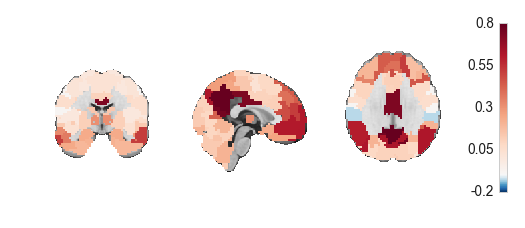

In [951]:
conn_vec_tmp = []



for k in range(len(list_conn_sites)):
    if k==0:
        conn_vec_tmp = list_conn_sites[k]
    else:
        conn_vec_tmp = np.hstack((conn_vec_tmp,list_conn_sites[k]))

print conn_vec_tmp.mean(axis=1).shape
im_ref = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/Multisite/figures/network_basc.mnc')
im_ref = nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())
    
var_sources = ts.vec2mat(conn_vec_tmp.mean(axis=1),0)[0,:]

nn_map = ts.vec2map(var_sources,im_ref)
display = plotting.plot_anat(anat_img=anat_template,
                             display_mode='ortho',
                             cut_coords=(0,-7,30),
                             annotate=False,
                             draw_cross=False)

display.add_overlay(nn_map,
                    colorbar=True,
                    cmap=vis.get_cmap(var_sources),#cm.RdBu_r,
                    vmin=-0.2,
                    vmax=0.8)




(4950,)


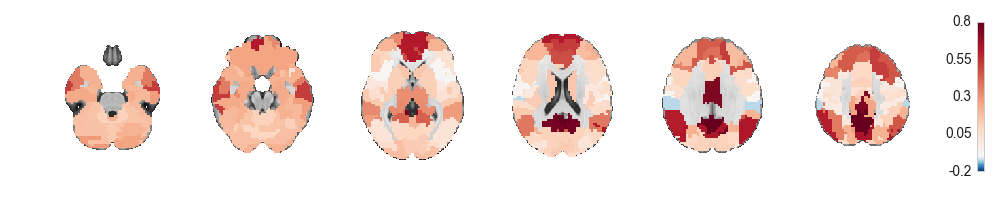

In [961]:
conn_vec_tmp = []



for k in range(len(list_conn_sites)):
    if k==0:
        conn_vec_tmp = list_conn_sites[k]
    else:
        conn_vec_tmp = np.hstack((conn_vec_tmp,list_conn_sites[k]))

print conn_vec_tmp.mean(axis=1).shape
im_ref = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/Multisite/figures/network_basc.mnc')
im_ref = nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())
    
var_sources = ts.vec2mat(conn_vec_tmp.mean(axis=1),0)[0,:]

nn_map = ts.vec2map(var_sources,im_ref)
display = plotting.plot_anat(anat_img=anat_template,
                             display_mode='z',
                             cut_coords=[-30,-20,0,20,30,45],
                             annotate=False,
                             draw_cross=False)

display.add_overlay(nn_map,
                    colorbar=True,
                    cmap=vis.get_cmap(var_sources),#cm.RdBu_r,
                    vmin=-0.2,
                    vmax=0.8)




In [ ]:
## plot intra site STD

##Intersite variance (plot the beta values)

[[ 0.04660993  0.10285088  0.03392475 ...,  0.01085679  0.0902187
   0.07427688]
 [ 0.17730597  0.04141442  0.00268841 ...,  0.08977422  0.12296     0.00709574]
 [ 0.10098057  0.22065059  0.04384568 ...,  0.08618769  0.01358664
   0.11845671]
 ..., 
 [ 0.02303082  0.04397218  0.0290244  ...,  0.00278901  0.09889635
   0.02898514]
 [ 0.01337143  0.02037152  0.05345553 ...,  0.12825511  0.03840275
   0.03564682]
 [ 0.06799959  0.0182994   0.00380388 ...,  0.05896372  0.17543482
   0.03245327]]
[[-0.04660993 -0.10285088  0.03392475 ..., -0.01085679  0.0902187
  -0.07427688]
 [-0.17730597  0.04141442  0.00268841 ..., -0.08977422  0.12296     0.00709574]
 [-0.10098057  0.22065059 -0.04384568 ..., -0.08618769  0.01358664
   0.11845671]
 ..., 
 [-0.02303082  0.04397218  0.0290244  ..., -0.00278901 -0.09889635
  -0.02898514]
 [ 0.01337143 -0.02037152 -0.05345553 ...,  0.12825511 -0.03840275
   0.03564682]
 [ 0.06799959  0.0182994  -0.00380388 ..., -0.05896372 -0.17543482
   0.03245327]]


(-0.2, 0.6)

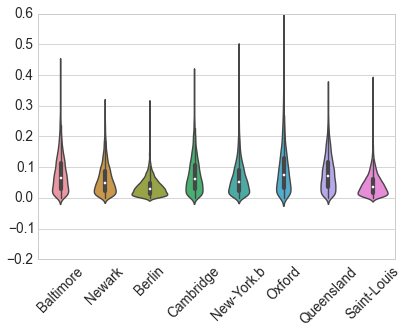

In [23]:
from Proteus.proteus.predic import clustering as hc
from Proteus.proteus.matrix import tseries as ts
from Proteus.proteus.visu import matrix as vis
import matplotlib.gridspec as gridspec
from scipy import stats
import statsmodels.stats.multitest as smm
from matplotlib.pylab import *

import copy
import nilearn
from nilearn import plotting
import nibabel as nib

reload(vis)
#reload(vis.matrix)
reload(ts)
reload(hc)

def mapvec(v,partition):
    new_map = copy.deepcopy(partition)
    im = new_map.get_data()
    
    part = partition.get_data()  
    for i in range(len(v)):
        idxs = np.where(part==(i+1))
        im[idxs] = v[i]
    return new_map

def get_stats(conns):
    # compute the mean, std, ...   
    return ts.vec2mat(conns.mean(axis=1)), ts.vec2mat(conns.std(axis=1),val_diag=0)

def gen_fig(list_conn_sites):
    anat_template = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/white_template.nii.gz')
    selected_network_idx = 0
    cutcoor = (0, 0,30)
    
    im_ref = nib.load('/Users/christian/Dropbox/McGill-publication/Papers/Multisite/figures/network_basc.mnc')
    im_ref = nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())
    
    for sidx in range(0,len(list_conn_sites)):

        conn_vec = list_conn_sites[sidx]
        site_mean, site_std = get_stats(conn_vec)
        #print(site_mean.min(),site_mean.max(), site_std.min(),site_std.max())
        if sidx == 0:
            all_sites = site_mean
        else:
            all_sites = all_sites + site_mean
            
        all_sites = all_sites / len(list_conn_sites)

    order = hc.hclustering(all_sites, 100)
    #ordered_mat = hc.ordermat(all_sites,order)
    #vis.mat(ordered_mat)
    
    site_names = ['Baltimore','Newark','Berlin','Cambridge','New-York.b','Oxford','Queensland','Saint-Louis']
    lim_mean = [-0.8,0.8]
    lim_mean_diff = [0,1]#[-0.3,0.3]
    lim_std  = [0,.3]
    fig = plt.figure(figsize=(16, 16),dpi=150)
    sns.set_context('paper',font_scale=1.7)
    fig.patch.set_facecolor('white')
    grid1 = gridspec.GridSpec(4,2, wspace=0.0, hspace=0.0)
    #grid1.update(wspace=0.0, hspace=0.0, bottom=0.0, top=0.5, left=0, right=0)
    grid1.update(wspace=0.1, hspace=0.01, left=0.01, right=0.48, bottom=0.7,top=1.)
    
    all_rejected = np.array([])
    all_avg = np.array([])
    
    for sidx in range(0,len(list_conn_sites)):
        
        if sidx > 0:
            conn_vec = list_conn_sites[sidx-1]
            site_mean, site_std = get_stats(conn_vec)
        
        # compare to all other sites
        #grid2 = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=grid1[sidx,col_idx], wspace=0.05,hspace=0.01)

        #grid2 = gridspec.GridSpec(len(list_conn_sites), 2, subplot_spec=grid1[sidx], wspace=0.05, hspace=0.0)
        #gs2 = gridspec.GridSpec(len(list_conn_sites), 2)
        site_mean_tmp, site_std_tmp = get_stats(list_conn_sites[sidx])


        ## difference computation
        
        conn_vec_tmp = []

        for k in range(len(list_conn_sites)):
            if k==0:
                conn_vec_tmp = list_conn_sites[k]
            else:
                conn_vec_tmp = np.hstack((conn_vec_tmp,list_conn_sites[k]))

        x_=[]
        contrast=[]
        for k in range(0,len(demog_data)):
            tmp_x = sm.tools.add_constant(demog_data[k])
            if k==sidx:
                if len(x_)==0:
                    contrast = np.ones(tmp_x.shape[0])
                    x_ = tmp_x
                else:
                    contrast = np.hstack((contrast,np.ones(tmp_x.shape[0])))
                    x_ = np.vstack((x_,tmp_x))
            else:
                if len(x_)==0:
                    contrast = np.zeros(tmp_x.shape[0])
                    x_ = tmp_x
                else:
                    contrast = np.hstack((contrast,np.zeros(tmp_x.shape[0])))
                    x_ = np.vstack((x_,tmp_x))

        x_ = np.hstack((contrast[:,np.newaxis],x_))
        beta = []
        #print conn_vec_tmp.shape
        for nn in range(conn_vec_tmp.shape[0]):
        #for nn in range(2):
            y_ = conn_vec_tmp[nn,:]
            glm_ = sm.GLM(y_, x_)
            res = glm_.fit()
            #print(res.summary())
            beta.append(res.params[0])
        beta = np.array(beta)
        #rejected , pvaluecorrected = smm.multipletests(pval, alpha=0.05, method='fdr_bh')[:2]
        if len(all_rejected)==0:
            all_rejected = beta
        else:
            all_rejected = np.vstack((all_rejected,beta))
        
                    
    return all_rejected
    
    

    # include the color bars 2
    #plt.savefig(main_path + 'figures/alldiff_multisite.pdf')
    #plt.savefig(main_path + 'figures/alldiff_multisite.png')
    
                

all_beta = gen_fig(list_conn_sites)

conn_vec_tmp = []
site_names = ['Baltimore','Newark','Berlin','Cambridge','New-York.b','Oxford','Queensland','Saint-Louis']
for k in range(len(list_conn_sites)):
    if k==0:
        conn_vec_tmp = list_conn_sites[k].std(axis=1)
    else:
        conn_vec_tmp = np.vstack((conn_vec_tmp,list_conn_sites[k].std(axis=1)))

n, p = 40, 8
print np.abs(all_beta.T)
print all_beta.T

# Use cubehelix to get a custom sequential palette
#pal = sns.cubehelix_palette(p, rot=-.5, dark=.3)
plt.figure()
conn_vec_tmp = pd.DataFrame(np.abs(all_beta.T),columns=site_names)
# Show each distribution with both violins and points

ax = sns.violinplot(data=conn_vec_tmp)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
ax.set_ylim(-0.2,0.6)




(4950, 8)
Ttest_relResult(statistic=317.34004480086872, pvalue=0.0)


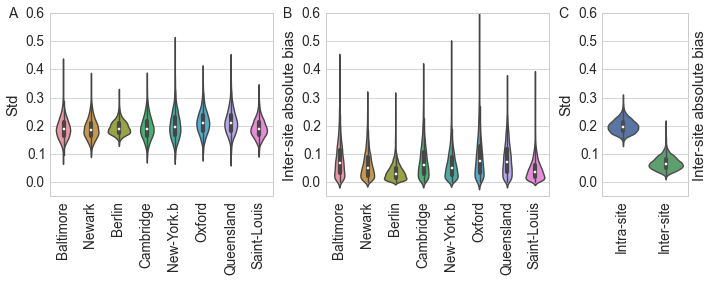

In [24]:
from scipy import stats

site_names = ['Baltimore','Newark','Berlin','Cambridge','New-York.b','Oxford','Queensland','Saint-Louis']

fig=plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((1,5), (0,0),colspan=2)
for k in range(len(list_conn_sites)):
    if k==0:
        conn_vec_tmp = list_conn_sites[k].std(axis=1)
    else:
        conn_vec_tmp = np.vstack((conn_vec_tmp,list_conn_sites[k].std(axis=1)))

n, p = 40, 8
conn_vec_tmp = conn_vec_tmp.T
intra_var = conn_vec_tmp.mean(axis=1)

conn_vec_tmp = pd.DataFrame(conn_vec_tmp,columns=site_names)
print conn_vec_tmp.shape
# Use cubehelix to get a custom sequential palette
pal = sns.cubehelix_palette(p, rot=-.5, dark=.3)

#fig=plt.figure(figsize=(5, 4))
# Show each distribution with both violins and points
ax = sns.violinplot(data=conn_vec_tmp,ax=ax1)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ax.set_ylim(-0.05,0.6)
ax.set_ylabel('Std')
ax.text(-2,0.6,'A',horizontalalignment='left',verticalalignment='center',size=14)
#fig.tight_layout()
#plt.savefig(main_path + 'figures/boxplot_intrasite_var.png')




## detailled version
conn_vec_tmp = pd.DataFrame(np.abs(all_beta.T),columns=site_names)
# Show each distribution with both violins and points

ax2 = plt.subplot2grid((1,5), (0, 2),colspan=2)
ax = sns.violinplot(data=conn_vec_tmp,ax=ax2)

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ax.set_ylim(-0.05,0.6)
ax.set_ylabel('Inter-site absolute bias')
ax.text(-2,0.6,'B',horizontalalignment='left',verticalalignment='center',size=14)

#plt.savefig(main_path + 'figures/boxplot_inter_var.png')


## summary std
#fig=plt.figure(figsize=(5, 4))
ax3 = plt.subplot2grid((1,5), (0, 4))
tmp_data = np.hstack((intra_var[:,np.newaxis],np.abs(all_beta.T).mean(axis=1)[:,np.newaxis]))
conn_vec_tmp = pd.DataFrame(tmp_data,columns=['Intra-site', 'Inter-site'])
# Show each distribution with both violins and points
ax = sns.violinplot(data=conn_vec_tmp,ax=ax3)
ax.set_ylim(-0.05,0.6)
ax.set_ylabel('Std')
ax.text(-1.5,0.6,'C',horizontalalignment='left',verticalalignment='center',size=14)
ax2 = ax.twinx()
ax2.set_ylabel('Inter-site absolute bias')
ax2.set_ylim(-0.05,0.6)
ax2.yaxis.grid(False)
ax2.yaxis.set_ticks([])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90)



fig.tight_layout()
fig.subplots_adjust(hspace=.4)
plt.savefig(main_path + 'figures/boxplot_intra_inter_var.png')

print stats.ttest_rel(conn_vec_tmp['Intra-site'].values,conn_vec_tmp['Inter-site'].values)




In [25]:
#print stats.wilcoxon(conn_vec_tmp['Intra-site'].values,conn_vec_tmp['Intra-site'].values)
print stats.ttest_ind(conn_vec_tmp['Intra-site'].values,conn_vec_tmp['Inter-site'].values)

dd=mean(conn_vec_tmp.values,axis=0)
print dd
print dd[0]/dd[1]


Ttest_indResult(statistic=275.99071509307873, pvalue=0.0)
[ 0.19763944  0.06583359]
3.00210619084


In [ ]:
## network

In [26]:
reload(ts)
print np.tril_indices_from(np.array([[1,2,3],[4,5,6],[7,8,9]]), -1)
s=np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])

s_vec = np.array([5,9,13,10,14,15])

print ts.mat2vec(s)
print ts.vec2mat(s_vec)
print np.tril_indices_from(s, -1)

tril_indices(n=4,k=-1,m=4)

print s[np.tril_indices_from(s, -1)]
print np.triu_indices_from(s, 0)
idx = triu_indices(n=4,k=1,m=4)
print idx
#sorted_idx = np.argsort(idx,axis=-1)
print idx[0]

(array([1, 2, 2]), array([0, 0, 1]))
[ 5  9 13 10 14 15]
[[  1.   5.   9.  13.]
 [  5.   1.  10.  14.]
 [  9.  10.   1.  15.]
 [ 13.  14.  15.   1.]]
(array([1, 2, 2, 3, 3, 3]), array([0, 0, 1, 0, 1, 2]))
[ 5  9 10 13 14 15]
(array([0, 0, 0, 0, 1, 1, 1, 2, 2, 3]), array([0, 1, 2, 3, 1, 2, 3, 2, 3, 3]))
(array([0, 0, 0, 1, 1, 2]), array([1, 2, 3, 2, 3, 3]))
[0 0 0 1 1 2]


In [293]:
xx=load_file('/Users/christian/Dropbox/McGill-publication/Papers/Multisite/figures/connectomes/connectome_basc_sub02953' )
print xx.keys()
print xx.get('G').shape

['__version__', 'G', '__header__', '__globals__', 'thresh', 'ind_roi', 'type', 'conn']
(4950, 1)


In [160]:
import nilearn
from nilearn import plotting
import nibabel as nib

#im_ref = nib.load('sci100_scg100_scf100/brain_partition_consensus_group_sci100_scg100_scf100.mnc.gz')
im_ref = nib.load('basc_cambridge_sc100.mnc.gz')

#im_ref = nib.load('/Users/christian/neurorx/glm_connectome_local/sci100cambridge/effect_lhvol/data_to_del.mnc')
'''
im_ref
data = dm_vol
img = nib.Nifti1Image(data, np.eye(4))
img.get_data_dtype() == np.dtype(np.int16)
img.header.get_xyzt_units()
nib.save(img, os.path.join('build',main_path + '/test4d.nii.gz'))

from nilearn import datasets

###############################################################################
# Retrieve the data

localizer_dataset = datasets.fetch_localizer_contrasts(
    ["left vs right button press"],
    n_subjects=2,
    get_tmaps=True)
localizer_tmap_filename = localizer_dataset.tmaps[1]



plotting.plot_glass_brain(img,threshold=0)
#vis.mat(partition[:,:,20,5])
#gen_fig(list_conn_sites)

partition[:,:,:,4].max()


###############################################################################
# Retrieve the data

localizer_dataset = datasets.fetch_localizer_contrasts(
    ["left vs right button press"],
    n_subjects=2,
    get_tmaps=True)
localizer_tmap_filename = localizer_dataset.tmaps[1]

'''

###############################################################################
# demo glass brain plotting
#                          threshold=80,
plotting.plot_glass_brain(im_ref,
                          colorbar=True ,
                          threshold=1,
                          display_mode='xz'
                          
                         )

#plotting.plot_glass_brain(localizer_tmap_filename, title='plot_glass_brain',
#                          black_bg=True, display_mode='xz', threshold=3)

#import matplotlib.pyplot as plt
plt.show()

cut_coords = (0, 0, 30)

plotting.plot_anat(im_ref, cut_coords=cut_coords,
                   title='Anatomy image')
plotting.plot_anat(im_ref, cut_coords=cut_coords,
                   title='Anatomy image')


ImageFileError: Filespec "basc_cambridge_sc100.mnc.gz" does not look right for class <class 'nibabel.minc2.Minc2Image'>

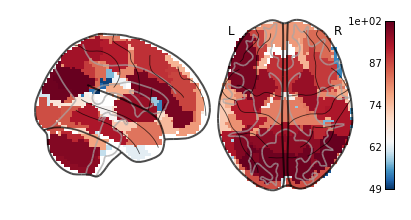

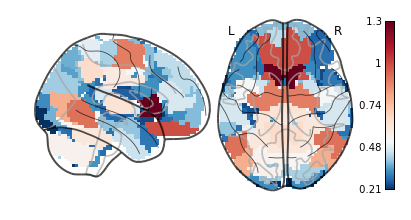

In [202]:

import copy

def mapvec(v,partition):
    new_map = copy.deepcopy(partition)
    im = new_map.get_data()
    
    part = partition.get_data()  
    for i in range(len(v)):
        idxs = np.where(part==(i+1))
        im[idxs] = v[i]
    return new_map

def mapvec2(v,partition):
    new_map = copy.deepcopy(partition)
    im = new_map.get_data()
    
    part = partition.get_data()  
    for i in range(len(v)):
        idxs = np.where(part==(i+1))
        if (i+1) == 1:
            im[idxs] = 0.5
        else:
            im[idxs] = 0
        
    return new_map


im_ref = nib.load('basc_cambridge_sc100.mnc')
im_ref = nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())

#nn_map = mapvec2(site_mean[1,:],im_ref)
#print im_ref.get_data() == nn_map.get_data()
#print(im_ref)
#print(nib.Minc2Image(im_ref.get_data(), im_ref.get_affine()))
#print(copy.deepcopy(nib.Minc2Image(im_ref.get_data(), im_ref.get_affine())))

nn_map = mapvec(site_mean[1,:],im_ref)
cmap_ = vis.get_cmap(nn_map.get_data(),[-0.2,0.5])
plotting.plot_glass_brain(im_ref,
                          cmap=cmap_,
                          colorbar=True ,
                          display_mode='xz'
                         )
nn_map = mapvec(site_mean[10,:],im_ref)
cmap_ = vis.get_cmap(nn_map.get_data(),[-0.2,0.5])
plotting.plot_glass_brain(nn_map,
                          cmap=cmap_,
                          colorbar=True ,
                          display_mode='xz'
                         )



#vis.mat(img[28,:,:])

In [122]:
print im_ref
new_map = copy.deepcopy(im_ref)
print new_map.get_data()

<class 'nibabel.minc1.Minc1Image'>
data shape (46, 64, 53)
affine: 
[[   0.    0.    3.  -78.]
 [   0.    3.    0. -112.]
 [   3.    0.    0.  -50.]
 [   0.    0.    0.    1.]]
metadata:
[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 ..., 
 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0

Exception AttributeError: "'GzipFile' object has no attribute 'fileobj'" in <bound method netcdf_file.close of <nibabel.externals.netcdf.netcdf_file object at 0x10bdab950>> ignored


In [15]:
localizer_tmap_filename

'/Users/christian/nilearn_data/brainomics_localizer/brainomics_data/S02/t_map_left_auditory_&_visual_click_vs_right_auditory&visual_click.nii.gz'

In [ ]:
0.2/(0.2+1.2)

a=np.array([1,2,3])
n=3
(2**(n+4))+n

(16*n)+2*n+1

frame1 = plt.gca()
frame1.axes.get_yaxis().set_visible(True)
frame1.axes.get_yaxis()
        


In [ ]:
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[0, 1:1+2])
ax2 = plt.subplot(gs[1,:-1])
ax3 = plt.subplot(gs[1:, -1])
ax4 = plt.subplot(gs[-1,0])
ax5 = plt.subplot(gs[-1,-2])

In [536]:

reload(vis.matrix)
t, prob = stats.ttest_ind(list_conn_sites[1],list_conn_sites[5],1,equal_var=False)
t, prob

vis.matrix.mat(ts.vec2mat(prob)*(ts.vec2mat(prob)<0.001))

cmap = vis.matrix.get_cmap(prob,[0,1])

import matplotlib as mpl
fig = plt.figure(figsize=(3,3))
ax1 = fig.add_axes([0.8, 0.05, 0.1, 0.9])
vis.matrix.color_bar_vertical(ax1, cmap, [0,1])
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.1])
vis.matrix.color_bar_horizontal(ax1, cmap, [0,1])

plt.subplot(grid2[0, :])

2+2

TypeError: reload() argument must be module